## Detect Pneumonia Using X-Ray Images with CNNs and Transfer Learning
The project is focused on developing a cutting edge technology to assist hospitals in diagnosis of pheneumonia patients, particularly children. A dataset comprised of 5856 chest X-ray images from children, collected by reserachers in UCSD is used in this analysis. **bold text**

### Load the Dataset

In [ ]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz

--2024-10-20 00:57:03--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 54.231.199.193, 52.217.160.113, 52.216.93.203, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|54.231.199.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223407715 (1.1G) [application/x-gzip]
Saving to: ‘xray_dataset.tar.gz’

xray_dataset.tar.gz 100%[===================>]   1.14G  46.9MB/s    in 26s     

2024-10-20 00:57:29 (45.6 MB/s) - ‘xray_dataset.tar.gz’ saved [1223407715/1223407715]



In [ ]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers,models,Model,Input,applications,initializers
%matplotlib inline


In [ ]:
# Uncompress the datafile

import tarfile
def extract_tar_gz(file_path,output_path):
  with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(path=output_path)

extract_tar_gz('xray_dataset.tar.gz','xray_dataset')

In [ ]:
# Load the datasets

train_set=tf.keras.utils.image_dataset_from_directory(
    directory='xray_dataset/chest_xray/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256,256),
    validation_split=0.2,
    subset='training',
    seed=42,
    shuffle=True
)


validation_set=tf.keras.utils.image_dataset_from_directory(
    directory='xray_dataset/chest_xray/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256,256),
    validation_split=0.2,
    subset='validation',
    seed=42,
    shuffle=True
)


test_set=tf.keras.utils.image_dataset_from_directory(
    directory='xray_dataset/chest_xray/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256,256),
    shuffle=True
)

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


### Preprocess the dataset

In [ ]:
# Loading Normalized datasets

normalization_layer=layers.Rescaling(1/255)

normalized_train_set=train_set.map(lambda x,y: (normalization_layer(x),y))
normalized_validation_set=validation_set.map(lambda x,y: (normalization_layer(x),y))
normalized_test_set=test_set.map(lambda x,y: (normalization_layer(x),y))

### Data Exploration

In [ ]:
train_set.class_names

['NORMAL', 'PNEUMONIA']

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


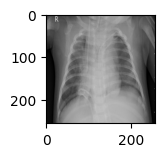

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


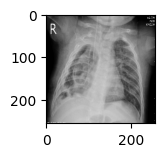

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


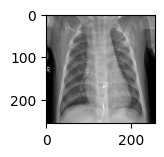

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


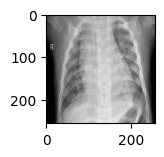

Training Set Image Label: [1. 0.]
Training Set Image Shape: (256, 256, 3)


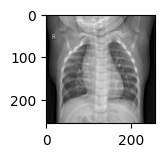

Training Set Image Label: [1. 0.]
Training Set Image Shape: (256, 256, 3)


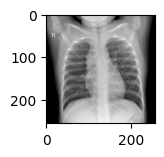

In [ ]:
train_set_elem=normalized_train_set.take(1)
for images,labels in train_set_elem:
  images=images.numpy()
  labels=labels.numpy()
  for i in range (6):
    plt.subplot(3,2,i+1)
    plt.imshow(images[i])
    print(f"Training Set Image Label: {labels[i]}")
    print(f"Training Set Image Shape: {images[i].shape}")

    plt.show()

Test Set Image Label: [1. 0.]
Trest Set Image Shape: (256, 256, 3)


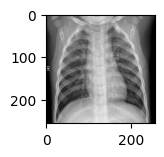

Test Set Image Label: [0. 1.]
Trest Set Image Shape: (256, 256, 3)


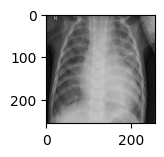

Test Set Image Label: [1. 0.]
Trest Set Image Shape: (256, 256, 3)


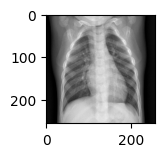

Test Set Image Label: [1. 0.]
Trest Set Image Shape: (256, 256, 3)


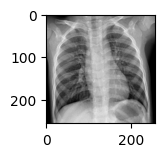

Test Set Image Label: [0. 1.]
Trest Set Image Shape: (256, 256, 3)


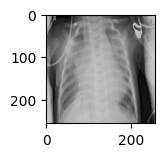

Test Set Image Label: [0. 1.]
Trest Set Image Shape: (256, 256, 3)


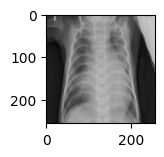

In [ ]:
test_set_elem=normalized_test_set.take(1)
for images,labels in test_set_elem:
  images=images.numpy()
  labels=labels.numpy()

  for i in range(6):
    plt.subplot(3,2,i+1)
    plt.imshow(images[i])
    print(f"Test Set Image Label: {labels[i]}")
    print(f"Trest Set Image Shape: {images[i].shape}")

    plt.show()


Even though the images seems to be in greyscale, from the shape of the images it shows these images are RGB images with three chanels.The images don't seem to have a lot of information, but, because of the overlap of ribs and lungs, it could be difficult to extract features specific to the infection. A more complex model could perhaps manage to extract relevant features. Based on the way how the images were captured,adding rortation to images as a data augmentation step could help extract more informations from the images.

### First Model Simple CNN I

In [ ]:
model1=models.Sequential()

model1.add(layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',
                     padding='same',strides=2,input_shape=(256,256,3)))
model1.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))
model1.add(layers.Flatten())

model1.add(layers.Dense(128,activation='relu'))
model1.add(layers.Dense(2))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model1.compile(optimizer=opt,loss=loss,metrics=['accuracy'])

model1.fit(normalized_train_set,validation_data=normalized_validation_set,
           epochs=5)







Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - accuracy: 0.7905 - loss: 1.5148 - val_accuracy: 0.9197 - val_loss: 0.2289
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - accuracy: 0.9587 - loss: 0.1204 - val_accuracy: 0.9608 - val_loss: 0.1229
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 285ms/step - accuracy: 0.9734 - loss: 0.0795 - val_accuracy: 0.9790 - val_loss: 0.0733
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 261ms/step - accuracy: 0.9836 - loss: 0.0550 - val_accuracy: 0.9771 - val_loss: 0.0738
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 258ms/step - accuracy: 0.9928 - loss: 0.0279 - val_accuracy: 0.9771 - val_loss: 0.0714


Both the validation and training accuracies are quite high even though the model was trained for only 5 epochs.This can happen because the model could be learning to classify based on features that might not be that relevant to the infection.
 It is possible the model is overfitting. Adding regularization, data augmentation, and more fully-connected layers could help prevent some overfitting while still ensuring good performance.

### Simple CNN II

In [ ]:
model2=models.Sequential()

model2.add(layers.RandomZoom(height_factor=0.1,fill_mode='reflect'))
model2.add(layers.RandomRotation(factor=0.2))
model2.add(layers.RandomContrast(factor=0.2))


model2.add(layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',
                     padding='same',strides=2,input_shape=(256,256,3)))
model2.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))

model2.add(layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',
                     padding='same',strides=2))
model2.add(layers.MaxPooling2D(pool_size=(3,2),strides=2))
model2.add(layers.Flatten())


model2.add(layers.Dense(256,activation='relu'))
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(128,activation='relu'))
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(64,activation='relu'))
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(2))


early_stopping_callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model2.compile(optimizer=opt,loss=loss,metrics=['accuracy'])




model2.fit(normalized_train_set,validation_data=normalized_validation_set,
           epochs=10,callbacks=[early_stopping_callback])


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 264ms/step - accuracy: 0.6972 - loss: 0.6569 - val_accuracy: 0.7600 - val_loss: 0.5729
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 253ms/step - accuracy: 0.7363 - loss: 0.5576 - val_accuracy: 0.7036 - val_loss: 0.5051
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 46s 289ms/step - accuracy: 0.7965 - loss: 0.4092 - val_accuracy: 0.9054 - val_loss: 0.2173
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 289ms/step - accuracy: 0.8598 - loss: 0.3263 - val_accuracy: 0.8958 - val_loss: 0.2632
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 254ms/step - accuracy: 0.8698 - loss: 0.3257 - val_accuracy: 0.9264 - val_loss: 0.1724
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 266ms/step - accuracy: 0.8933 - loss: 0.2891 - val_accuracy: 0.9082 - val_loss: 0.2156
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - accuracy: 0.9034 - loss: 0.2517 - val_accuracy: 0.9398 - val_loss: 0.1548
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 254ms/step - accuracy: 0.9122 - loss: 0



The architecture was modified a few times to try and reduce overfitting while still yielding reasonable performance. The experimentation included:

    Trying different combinations of data augmentation layers.
    Increasing the number of filters, trying different sizes, different strides, and number of convolutional layers.
    Adding more fully-connected layers with a different number of units.
    Removing batch normalization layers after the fully-connected layers and replacing them with dropout layers. Before this change, the model's performance was a bit erratic.
    Reducing the learning rate helped the model to converge.
    Adding an early stopping callback that would stop the training if the validation loss didn't decrease for three consecutive epochs. Using the restore_best_weights argument ensured that the model would use weights from the epoch with the lowest validation loss only.



### Second Model: Transfer Learning

In [ ]:
base_model=applications.resnet_v2.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(256,256,3)
)
base_model.trainable=False
input_layer=Input(shape=(256,256,3))
preprocessed_input_layer=applications.resnet_v2.preprocess_input(
    input_layer
)
preprocessed_input_layer = layers.RandomZoom(height_factor=0.1)(preprocessed_input_layer)
preprocessed_input_layer = layers.RandomRotation(factor=0.2)(preprocessed_input_layer)

features_layer=base_model(preprocessed_input_layer,training=False)

global_pooling=layers.GlobalAveragePooling2D()(features_layer)

fc1=layers.Dense(512)(global_pooling)
fc1 = layers.ReLU()(fc1)

fc2 = layers.Dense(128)(fc1)
fc2 = layers.ReLU()(fc2)

fc3 = layers.Dense(32)(fc2)
fc3 = layers.ReLU()(fc3)

output = layers.Dense(2)(fc3)

model3=Model(inputs=preprocessed_input_layer,outputs=output)
model3.summary()


early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model3.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

model3.fit(train_set, epochs=10, validation_data=validation_set, callbacks=[early_stopping_callback])


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_242CLONE (InputLayer)   │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 8, 8, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,683,746 (94.16 MB)

 Trainable params: 1,118,946 (4.27 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 79s 486ms/step - accuracy: 0.6999 - loss: 108.3628 - val_accuracy: 0.8709 - val_loss: 0.3014
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 307ms/step - accuracy: 0.8658 - loss: 0.3316 - val_accuracy: 0.8757 - val_loss: 0.3031
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 304ms/step - accuracy: 0.8828 - loss: 0.2755 - val_accuracy: 0.9312 - val_loss: 0.1828
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 304ms/step - accuracy: 0.9269 - loss: 0.1864 - val_accuracy: 0.9340 - val_loss: 0.1697
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 282ms/step - accuracy: 0.9262 - loss: 0.1766 - val_accuracy: 0.9235 - val_loss: 0.1898
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 301ms/step - accuracy: 0.9315 - loss: 0.1647 - val_accuracy: 0.9063 - val_loss: 0.2090


In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable=False

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model3.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

model3.fit(train_set, epochs=5, validation_data=validation_set, callbacks=[early_stopping_callback])

Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 410ms/step - accuracy: 0.9732 - loss: 0.0726 - val_accuracy: 0.9704 - val_loss: 0.0791
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 279ms/step - accuracy: 0.9844 - loss: 0.0526 - val_accuracy: 0.9732 - val_loss: 0.0770
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 286ms/step - accuracy: 0.9776 - loss: 0.0611 - val_accuracy: 0.9761 - val_loss: 0.0703
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - accuracy: 0.9833 - loss: 0.0463 - val_accuracy: 0.9742 - val_loss: 0.0763
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 307ms/step - accuracy: 0.9814 - loss: 0.0520 - val_accuracy: 0.9742 - val_loss: 0.0678


### Evaluating on the test set

In [ ]:
model2_test_loss, model2_test_acc = model2.evaluate(normalized_test_set)

print(f"Test set accuracy of first model: {model2_test_acc}")

model3_test_loss, model3_test_acc = model3.evaluate(normalized_test_set)

print(f"Test set accuracy of second model: {model3_test_acc}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.8663 - loss: 0.4021
Test set accuracy of first model: 0.8589743375778198
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.6125 - loss: 14.9472
Test set accuracy of second model: 0.625
